In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Used for exporting pandas tables "pip install dataframe-image"
import dataframe_image as dfi

import datetime

import pyspark.pandas as ps
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, from_unixtime, date_trunc
import pyspark.sql.functions as F

In [259]:
try:
    spark.stop()
except NameError:
    pass

### Helper Functions

Reusable Functions 

In [260]:
def save_df_image(df):
    """
    Save DataFrame as an image with a colored table.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be saved as an image.

    Returns:
    None
    """

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Hide the axes
    ax.axis("off")

    # Plot the DataFrame as a table with alternating column colors
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        loc="center",
        cellLoc="center",
        colColours=["#6EC33C", "#913CC3"] * len(df.columns),
    )

    # Adjust font size
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Save the figure as an image (e.g., PNG)
    plt.savefig("table_image.png", bbox_inches="tight", pad_inches=0.5)


def style_df(df):
    # Set Colors
    styles = [
        {
            "selector": "th.col_heading",
            "props": [("background-color", "#14345a"), ("color", "white")],
        },
        {
            "selector": "th.blank",
            "props": [("background-color", "#14345a"), ("color", "white")],
        },
        {
            "selector": "tr:nth-child(even)",
            "props": [("background-color", "#002351"), ("color", "white")],
        },
        {
            "selector": "tr:nth-child(odd)",
            "props": [("background-color", "#062c54"), ("color", "white")],
        },
    ]

    # Apply the styles to the DataFrame
    styled_df = df.style.set_table_styles(styles)

    return styled_df


def flag_rows(df, column_name, check_list, flagged_column_name):
    """
    Flag rows in a PySpark DataFrame based on whether the value in a specified column is in a given list.

    Parameters:
    - df (pyspark.sql.DataFrame): The PySpark DataFrame to be modified.
    - column_name (str): The name of the column to check for values.
    - check_list (list): The list of values to check against.
    - flagged_column_name (str): The name of the new column to be created for the flags.

    Returns:
    pyspark.sql.DataFrame: The modified PySpark DataFrame with the new flagged column.

    This function takes a PySpark DataFrame, a column name, a list of values, and a flagged column name. It then adds a new column to the DataFrame
    that contains a flag (1 or 0) based on whether the values in the specified column are present in the given list.
    """

    def check_list_udf(value):
        return 1 if value in check_list else 0

    check_list_udf = udf(check_list_udf, IntegerType())

    df = df.withColumn(flagged_column_name, check_list_udf(df[column_name]))

    return df

In [261]:
# create a Spark session
spark = SparkSession.builder.master("local[4]").appName("Spark Churn").getOrCreate()

In [262]:
path = "mini_sparkify_event_data.json"
psdf = spark.read.json(path)
psdf.persist()

# userId is a string and NULL values shows as empty strings not NULL
psdf = psdf.withColumn("userId", col("userId").cast("int"))
psdf.printSchema()

# Build Temp Table for Future sql queries
psdf.createOrReplaceTempView("user_log")

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)



In [263]:
psdf.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [264]:
# Seperate column types
num_cols = [
    psdf.dtypes[i][0] for i in range(len(psdf.columns)) if psdf.dtypes[i][1] != "string"
]

obj_cols = [
    psdf.dtypes[i][0] for i in range(len(psdf.columns)) if psdf.dtypes[i][1] == "string"
]

Explroing Null Values

In [290]:
def unique_nulls_count(df):
    if isinstance(df, DataFrame):
        summary_counts = [
            {
                "Column": c,
                "UniqueCount": df[[c]].distinct().count(),
                "NullCount": df[[c]].filter(col(c).isNull()).count(),
                "Type": df[[c]].dtypes[0][1],
            }
            for c in df.columns
        ]
    if isinstance(df, pd.DataFrame):
        summary_counts = [
            {
                "Column": c,
                "UniqueCount": df[c].nunique(),
                "NullCount": df[c].isnull().sum(),
                "Type": df[c].dtype,
            }
            for c in df.columns
        ]

    # Create a Pandas DataFrame
    return pd.DataFrame(summary_counts).sort_values("UniqueCount")


# columns_with_nulls = [summary_counts_df.iloc[i][0] for i in range(summary_counts_df.shape[0]) if summary_counts_df.iloc[i][2] > 0]
summary_counts_df = unique_nulls_count(psdf.toPandas())
style_df(summary_counts_df.iloc[:9]).export_png("summary_counts(part1).png")
style_df(summary_counts_df.iloc[9:]).export_png("summary_counts(part2).png")
style_df(summary_counts_df)

,Column,UniqueCount,NullCount,Type
9,method,2,0,object
7,level,2,0,object
3,gender,2,8346,object
18,cancel_flag,2,0,int32
14,status,3,0,int64
1,auth,4,0,object
10,page,22,0,object
16,userAgent,56,8346,object
8,location,114,8346,object
5,lastName,173,8346,object


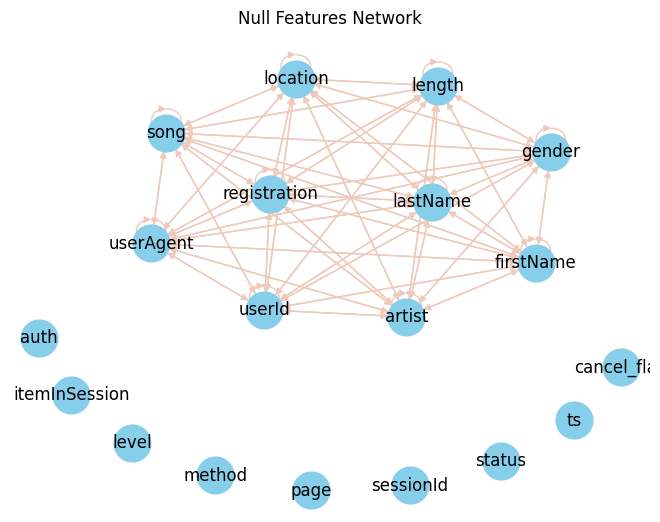

In [298]:
def null_combination_check(df):
    """
    Identify columns with null values and their related columns in a DataFrame.

    Parameters:
    - df (pyspark.sql.DataFrame or pd.DataFrame): The input DataFrame.

    Returns:
    dict: A dictionary where keys are columns with null values, and values are lists of related columns.
    """
    if isinstance(df, DataFrame):
        df = df.toPandas()

    null_relations = {}
    for column in df.columns:
        rows_with_nulls = df[df[column].isnull()]
        related_columns = rows_with_nulls.columns[
            rows_with_nulls.isnull().any()
        ].tolist()

        null_relations[column] = related_columns

    return null_relations


def null_graph(relationships, ignore_no_relations=False):
    """
    Visualize relationships between entities as a directed graph using NetworkX and Matplotlib.

    Parameters:
    - relationships (dict): A dictionary representing relationships between entities. Each key is an entity,
      and the corresponding value is a list of related entities.
    - ignore_no_relations (bool): If True, only entities with at least one relation will be included in the graph.
      If False (default), all entities and their relations will be considered.

    Returns:
    None

    This function takes a dictionary of relationships and creates a directed graph using NetworkX.
    Nodes in the graph represent entities, and directed edges represent relationships between entities.
    The graph is visualized using Matplotlib.
    """

    G = nx.DiGraph()

    # Add nodes and edges based on relationships
    for entity, related_entities in relationships.items():
        if ignore_no_relations and len(related_entities) == 0:
            # passes empty entities in loop
            continue

        G.add_node(entity)
        for related_entity in related_entities:
            G.add_edge(entity, related_entity)

    # Visualization
    pos = nx.kamada_kawai_layout(G)
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=700,
        node_color="skyblue",
        font_size=12,
        font_color="black",
        arrowsize=10,
        edge_color="#EEC9BC",
    )
    plt.title("Null Features Network")
    plt.show()


null_graph(null_combination_check(psdf), ignore_no_relations=False)

/var/folders/zp/9kxj13m57_v23k2hkwd8vz600000gn/T/ipykernel_84397/1063085435.py:28: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



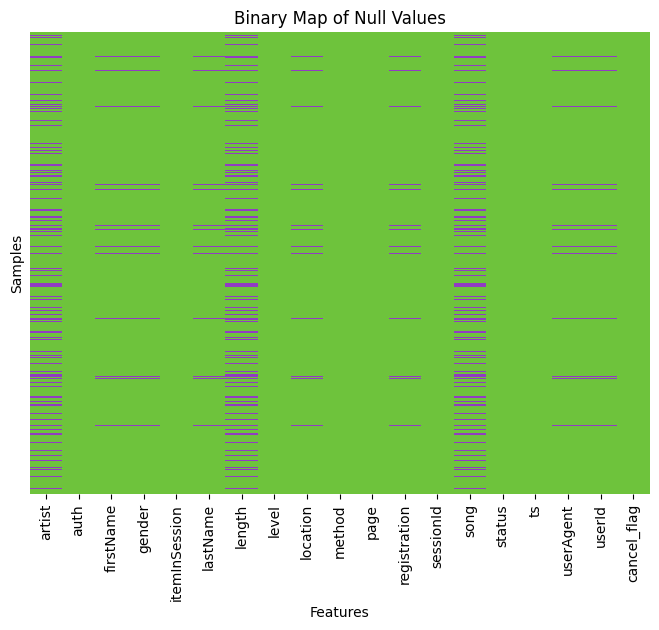

In [284]:
def binary_null_map(df):
    """
    Visualize the binary map of null values in a DataFrame using a heatmap.

    Parameters:
    - df (pyspark.sql.DataFrame or pd.DataFrame): The input DataFrame.

    Returns:
    None
    """

    if isinstance(df, DataFrame):
        df = df.toPandas()

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        df.isnull(),
        cbar=False,
        yticklabels=False,
        cmap=["#6EC33C", "#913CC3"],
        ax=ax,
    )

    ax.set_xlabel("Features")
    ax.set_ylabel("Samples")
    ax.set_title("Binary Map of Null Values")

    fig.show()


binary_null_map(psdf)

# Exploring Features

## Flag Cancelled Users

In [332]:
cancelled_user_list = (
    psdf[["userId"]]
    .filter(col("page").isin(["Cancellation Confirmation"]))
    .distinct()
    .toPandas()
    .userId.tolist()
)
# cancelled_user_list = psdf.rdd.map(lambda x: x.userId).collect()

psdf = flag_rows(psdf, "userId", cancelled_user_list, "cancel_flag")


# Check that the amount of 'Cancel COnfirmations' are equal to that of the amount of unique userIds that were flagged
assert (
    psdf[["page"]].filter(col("page") == "Cancellation Confirmation").count()
    == psdf.filter(col("cancel_flag") == 1).groupBy("userId").count().count()
)

## Churn By Gender

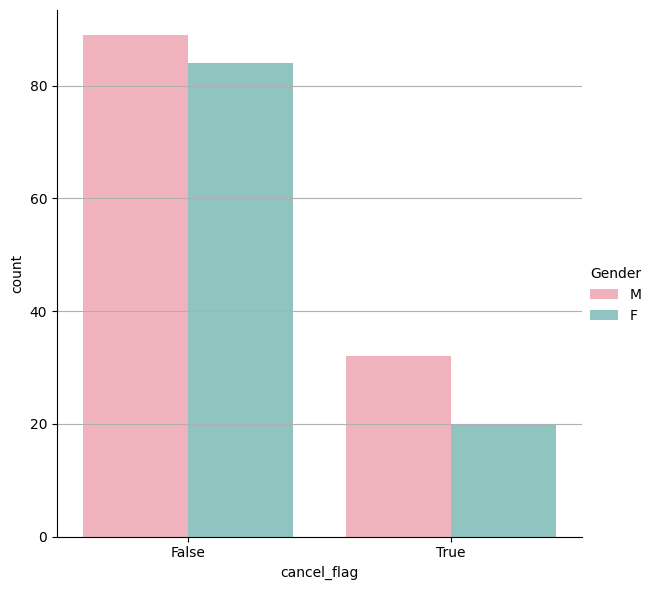

  Gender  cancel_flag  count
0      M        False     89
1      F        False     84
2      M         True     32
3      F         True     20


In [398]:
churn_by_gender = psdf.dropDuplicates(['userId']).select("Gender","cancel_flag").toPandas().dropna()
churn_by_gender = churn_by_gender.value_counts().reset_index()
churn_by_gender['cancel_flag'] = churn_by_gender['cancel_flag'].astype(bool)


chart = sns.catplot(
    kind = 'bar',
    data = churn_by_gender,
    x = 'cancel_flag', y = 'count', hue = 'Gender',
    errorbar="sd", palette="husl", alpha=.6, height=6
)

chart.despine(left=False)
plt.grid(axis = 'y')
plt.show()


print(churn_by_gender)


## Churn By Location

In [411]:
!pip install pycountry
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 11.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 10.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 5.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nltk 3.8.1 requires joblib, which is not installed.
nltk 3.8.1 requires regex>=2021.8.3, which is not installed.
nltk 3.8.1 requires tqdm, which is not installed.


In [503]:
import plotly.express as px

user_by_state = psdf.dropDuplicates(['userId']).select(['location','cancel_flag']).toPandas().dropna()
user_by_state['state'] = user_by_state['location'].str[-2:]
user_by_state.drop(columns='location', inplace =True)
user_by_state = user_by_state.value_counts().reset_index()

def state_heat(df):
    # Two Column DataFRam 1 column with states, the next stae value

    states = df.state.tolist()
    user_counts = df['count'].to_list()

    fig = px.choropleth(locations=states ,locationmode="USA-states", color=user_counts, scope="usa")
    
    fig.show()

cancel_filter = user_by_state['cancel_flag'] ==1
noncancel_filter = user_by_state['cancel_flag'] ==0
state_heat(user_by_state[cancel_filter].sort_values(by='state').reset_index(drop = True))

In [504]:
state_heat(user_by_state[noncancel_filter].sort_values(by='state').reset_index(drop = True))

In [457]:
churn_by_gender = psdf.dropDuplicates(['userId']).select("location","cancel_flag").toPandas().dropna()
churn_by_gender = churn_by_gender.value_counts().reset_index()
churn_by_gender['cancel_flag'] = churn_by_gender['cancel_flag'].astype(bool)

states = user_by_state.state.tolist()
user_counts = user_by_state['count'].to_list()

fig = px.choropleth(locations=states ,locationmode="USA-states", color=user_counts, scope="usa")
 
fig.show()

## Pages

In [269]:
psdf.groupBy("page").count().orderBy(col("count").desc()).toPandas()

,page,count
0,NextSong,228108
1,Home,14457
2,Thumbs Up,12551
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Login,3241
7,Logout,3226
8,Thumbs Down,2546
9,Downgrade,2055


In [270]:
null_user = psdf.filter(col("userId").isNull())
null_user.groupBy("page").count().orderBy(col("count").desc()).toPandas()

,page,count
0,Home,4375
1,Login,3241
2,About,429
3,Help,272
4,Register,18
5,Error,6
6,Submit Registration,5


In [271]:
temp_df = (
    psdf.na.drop(subset=["userAgent"])
    .groupBy("page")
    .count()
    .orderBy(col("count").desc())
    .toPandas()
)

temp_df.page.to_list()

['NextSong',
 'Thumbs Up',
 'Home',
 'Add to Playlist',
 'Add Friend',
 'Roll Advert',
 'Logout',
 'Thumbs Down',
 'Downgrade',
 'Settings',
 'Help',
 'Upgrade',
 'About',
 'Save Settings',
 'Error',
 'Submit Upgrade',
 'Submit Downgrade',
 'Cancel',
 'Cancellation Confirmation']

<Axes: xlabel='page'>

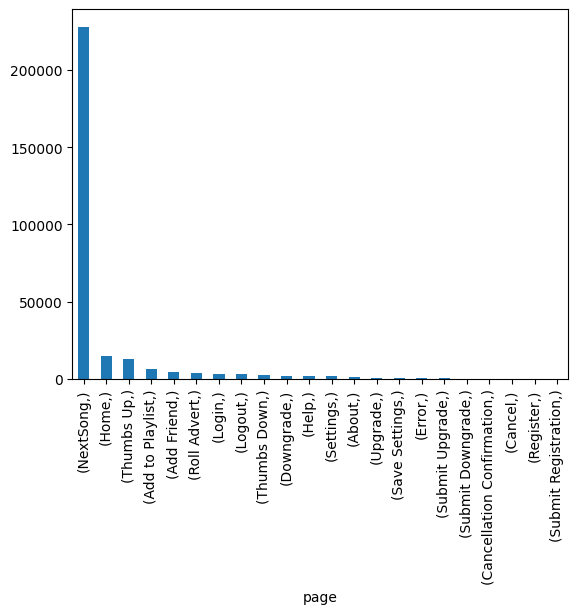

In [272]:
page_df = psdf[["page"]].toPandas()
page_df.value_counts().plot(kind="bar")

### Unique Counts of Upgrades/Downgrades


In [273]:
service_change = [
    "Downgrade",
    "Upgrade",
    "Submit Upgrade",
    "Submit Downgrade",
    "Cancel",
    "Cancellation Confirmation",
]


service_change_df = style_df(
    psdf[["page", "cancel_flag"]]
    .filter(col("page").isin(service_change))
    .groupBy("page")
    .count()
    .sort("count", ascending=False)
    .toPandas()
)

service_change_df.export_png("service_change.png")
service_change_df

,page,count
0,Downgrade,2055
1,Upgrade,499
2,Submit Upgrade,159
3,Submit Downgrade,63
4,Cancel,52
5,Cancellation Confirmation,52


In [274]:
service_change = [
    "Downgrade",
    "Submit Downgrade",
    "Cancel",
    "Cancellation Confirmation",
]


service_change_df = (
    psdf[["page", "userId", "cancel_flag"]]
    .filter(col("page").isin(service_change))
    .toPandas()
)

service_change_df = service_change_df.groupby("userId").value_counts().reset_index()

service_change_df = service_change_df.pivot(
    index="userId", columns="page", values="count"
).fillna(value=0)


# service_change_df[service_change_df['Cancellation Confirmation'] > 0].sum()

print(service_change_df)

page    Cancel  Cancellation Confirmation  Downgrade  Submit Downgrade
userId                                                                
2          0.0                        0.0       13.0               0.0
3          1.0                        1.0        2.0               0.0
4          0.0                        0.0       21.0               0.0
6          0.0                        0.0       41.0               0.0
9          0.0                        0.0       32.0               1.0
...        ...                        ...        ...               ...
300020     0.0                        0.0        1.0               0.0
300021     0.0                        0.0       17.0               1.0
300022     0.0                        0.0        1.0               0.0
300023     0.0                        0.0       12.0               1.0
300025     0.0                        0.0        7.0               0.0

[171 rows x 4 columns]


In [275]:
service_change_df[service_change_df["Submit Downgrade"] == 1].sort_values(
    "Downgrade", ascending=False
)

page,Cancel,Cancellation Confirmation,Downgrade,Submit Downgrade
userId,,,,
92,0.0,0.0,68.0,1.0
54,1.0,1.0,39.0,1.0
9,0.0,0.0,32.0,1.0
300011,0.0,0.0,32.0,1.0
74,0.0,0.0,31.0,1.0
100,0.0,0.0,30.0,1.0
81,0.0,0.0,26.0,1.0
300015,0.0,0.0,22.0,1.0
96,0.0,0.0,20.0,1.0


In [276]:
service_change_df

page,Cancel,Cancellation Confirmation,Downgrade,Submit Downgrade
userId,,,,
2,0.0,0.0,13.0,0.0
3,1.0,1.0,2.0,0.0
4,0.0,0.0,21.0,0.0
6,0.0,0.0,41.0,0.0
9,0.0,0.0,32.0,1.0
...,...,...,...,...
300020,0.0,0.0,1.0,0.0
300021,0.0,0.0,17.0,1.0
300022,0.0,0.0,1.0,0.0


In [293]:
service_change = [
    "Downgrade",
    "Submit Downgrade",
    "Cancel",
    "Cancellation Confirmation",
]


service_change_df = (
    psdf[["page", "userId"]].filter((col("page").isin(service_change))).toPandas()
)


service_change_df = service_change_df.groupby("userId").value_counts().reset_index()

service_change_df = service_change_df.pivot(
    index="userId", columns="page", values="count"
).fillna(value=0)

service_funnel = service_change_df.sum().sort_values(ascending=False)
data = dict(stages=service_funnel.keys(), numbers=service_funnel.values)
fig = px.funnel(data, x="numbers", y="stages")
fig.show()

service_change_df

page,Cancel,Cancellation Confirmation,Downgrade,Submit Downgrade
userId,,,,
2,0.0,0.0,13.0,0.0
3,1.0,1.0,2.0,0.0
4,0.0,0.0,21.0,0.0
6,0.0,0.0,41.0,0.0
9,0.0,0.0,32.0,1.0
...,...,...,...,...
300020,0.0,0.0,1.0,0.0
300021,0.0,0.0,17.0,1.0
300022,0.0,0.0,1.0,0.0


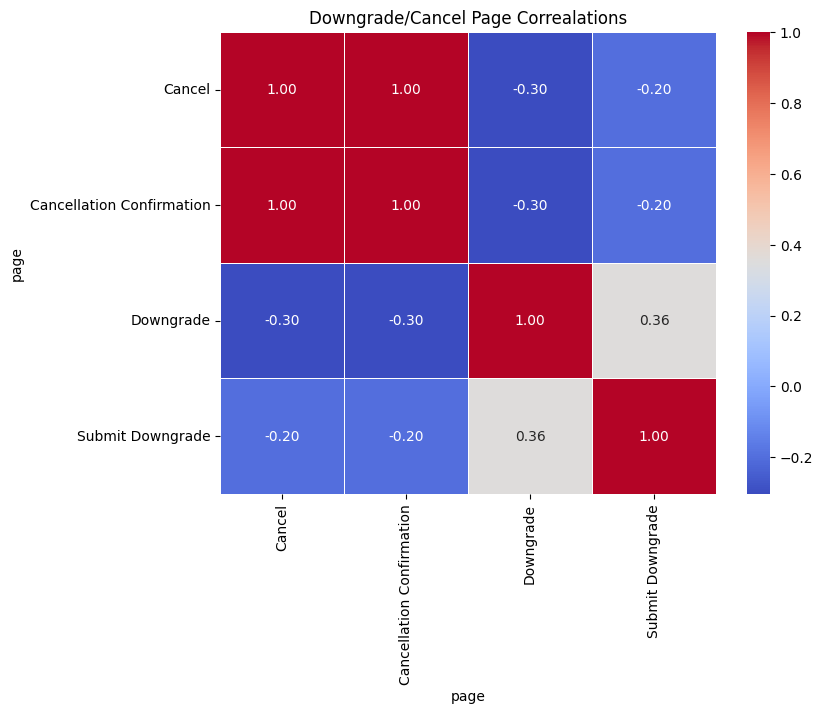

In [295]:
# Heatmap to show correlation between pages
plt.figure(figsize=(8, 6))
sns.heatmap(
    service_change_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5
)
plt.title("Downgrade/Cancel Page Correalations")
plt.show()

In [279]:
temp_df = psdf[["artist"]].toPandas().dropna().value_counts().reset_index()


temp_df = temp_df.rename(columns={"count": "song_plays"})


temp_df = temp_df["song_plays"].value_counts().reset_index()
temp_df = temp_df[temp_df["count"] > 10]

temp_df

,song_plays,count
0,1,5809
1,2,2616
2,3,1651
3,4,1075
4,5,757
...,...,...
67,83,11
68,103,11
69,73,11
70,75,11


# Feature Extraction

## Song Plays Per

In [280]:
psdf.createOrReplaceTempView("user_log_table")
spark.udf.register(
    "get_hour", lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).hour)
)
songs_in_hour = spark.sql(
    """
          SELECT get_hour(ts) AS hour, COUNT(*) as plays_per_hour
          FROM user_log_table
          WHERE page = "NextSong"
          GROUP BY hour
          ORDER BY cast(hour as int) ASC
          """
)

songs_in_hour_df = songs_in_hour.toPandas()

<Axes: >

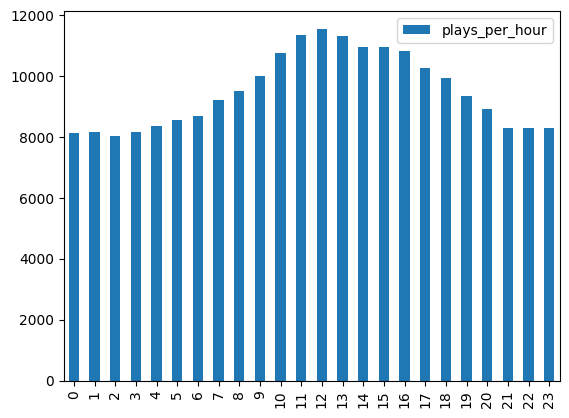

In [281]:
songs_in_hour_df.plot(kind="bar")

In [282]:
songs_listened = psdf.filter(col("artist").isNotNull()).groupBy(col("userId")).count()

songs_listened.show()

+------+-----+
|userId|count|
+------+-----+
|   148|  398|
|   137|  154|
|    85| 3616|
|    65| 2113|
|    53| 1746|
|   133|   32|
|    78|  254|
|    34|   53|
|   101| 1797|
|   126| 2577|
|   115| 1737|
|    81| 1974|
|    28| 1457|
|    76|  212|
|    27|  220|
|    26|  255|
|    44|  429|
|   103| 1073|
|    12|  867|
|    91| 2580|
+------+-----+
only showing top 20 rows



In [283]:
psdf[["userId", "user_cancel"]].filter(col("user_cancel") == 1).createOrReplaceTempView(
    "cancelled_users_lookup"
)
query = spark.sql(
    """
    SELECT DISTINCT
       ul.userId,
       ul.level,
       ul.user_cancel
    FROM user_log as ul 
    JOIN
       cancelled_users_lookup as cul
    ON
       cul.userId = ul.userId
    ORDER BY
       ul.userId ASC
"""
)

query.show()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `user_cancel` cannot be resolved. Did you mean one of the following? [`userAgent`, `sessionId`, `userId`, `firstName`, `gender`].;
'Project [userId#79060, 'user_cancel]
+- Project [artist#78934, auth#78935, firstName#78936, gender#78937, itemInSession#78938L, lastName#78939, length#78940, level#78941, location#78942, method#78943, page#78944, registration#78945L, sessionId#78946L, song#78947, status#78948L, ts#78949L, userAgent#78950, userId#79060, check_list_udf(userId#79060)#96812 AS cancel_flag#96813]
   +- Project [artist#78934, auth#78935, firstName#78936, gender#78937, itemInSession#78938L, lastName#78939, length#78940, level#78941, location#78942, method#78943, page#78944, registration#78945L, sessionId#78946L, song#78947, status#78948L, ts#78949L, userAgent#78950, cast(userId#78951 as int) AS userId#79060]
      +- Relation [artist#78934,auth#78935,firstName#78936,gender#78937,itemInSession#78938L,lastName#78939,length#78940,level#78941,location#78942,method#78943,page#78944,registration#78945L,sessionId#78946L,song#78947,status#78948L,ts#78949L,userAgent#78950,userId#78951] json


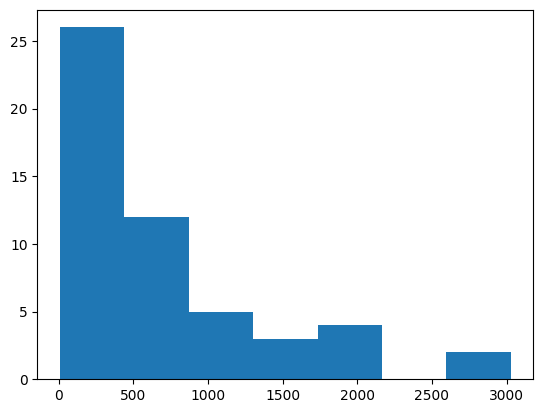

In [ ]:
songs_listened_cancel = spark.sql(
    """
    WITH song_count AS (
        SELECT userId
        , COUNT(*) AS song_count
        FROM user_log_table
        WHERE artist IS NOT NULL
        GROUP BY userID
    )
    SELECT DISTINCT
        u.userId,
        s.song_count
        
    FROM 
        user_log_table AS u
    JOIN 
        song_count AS s ON u.userId = s.userId
    WHERE 
        u.page = "Cancellation Confirmation"
    ORDER BY s.song_count ASC
"""
)

slc = songs_listened_cancel.toPandas()
plt.hist(slc.song_count, bins=int(np.sqrt(len(slc.song_count))))
plt.show()

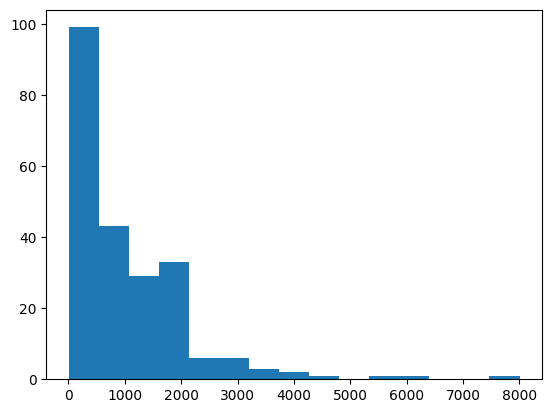

In [ ]:
psdf.createOrReplaceTempView("user_log_table")
songs_listened = spark.sql(
    """
    WITH song_count AS (
        SELECT userId, COUNT(*) AS song_count
        FROM user_log
        WHERE artist IS NOT NULL
        GROUP BY userID
    )
    SELECT DISTINCT
        u.userId,
        s.song_count
        
    FROM 
        user_log AS u
    JOIN 
        song_count AS s ON u.userId = s.userId
    WHERE 
        u.page != "Cancellation Confirmation"
    ORDER BY s.song_count ASC
"""
)

sl = songs_listened.toPandas()
plt.hist(sl.song_count, bins=int(np.sqrt(len(sl.song_count))))

plt.show()

In [ ]:
tsl = spark.sql(
    """
    SELECT userId, count(*) as song_count
    FROM user_log
    WHERE artist IS NOT NULL
    GROUP BY userId
    ORDER BY song_count DESC
"""
).toPandas()
tsl  # .song_count.plot(kind='hist' ,bins = 1 + int(np.log2(len(tsl.song_count))))

,userId,song_count
0,39,8002
1,92,5945
2,140,5664
3,300011,4619
4,124,4079
...,...,...
220,100024,22
221,100011,11
222,125,8
223,135,6


## Total Time Spent


In [ ]:
tts = spark.sql(
    """
                 SELECT userId
                 ,sessionId
                 FROM user_log
                 WHERE userId IS NOT NULL
                 """
).toPandas()


tts.groupby("userId").value_counts().reset_index()

,userId,sessionId,count
0,2,1,428
1,2,1639,188
2,2,1928,102
3,2,1487,97
4,2,637,55
...,...,...,...
3171,300025,285,15
3172,300025,234,13
3173,300025,34,8
3174,300025,122,8


In [ ]:
psdf[["userId", "page"]].filter((col("userId") == 39)).toPandas().value_counts()

userId  page            
39      NextSong            8002
        Thumbs Up            388
        Home                 355
        Add to Playlist      240
        Roll Advert          128
        Logout               124
        Add Friend           122
        Downgrade             73
        Thumbs Down           69
        Help                  46
        Settings              35
        About                 16
        Upgrade               14
        Error                  7
        Save Settings          6
        Submit Upgrade         4
        Submit Downgrade       3
Name: count, dtype: int64

## Page Interactions


In [ ]:
page_interactions = ["Thumbs Up", "Add to Playlist", "Thumbs Down", "Add Friend"]

psdf[["userId"]].filter(
    col("page").isin(page_interactions) & ~col("userID").isNull()
).toPandas().value_counts().reset_index()

,userId,count
0,39,819
1,300011,717
2,92,655
3,140,643
4,300021,568
...,...,...
216,100024,5
217,100017,4
218,100011,3
219,200007,3


In [ ]:
page_issues = ["Help", "Error"]

psdf[["userId"]].filter(
    col("page").isin(page_issues) & ~col("userID").isNull()
).toPandas().value_counts().reset_index()

,userId,count
0,39,53
1,92,43
2,140,41
3,300017,32
4,300011,32
...,...,...
192,47,1
193,100019,1
194,123,1
195,57,1


## User Account Level


User account level 

<Axes: xlabel='level'>

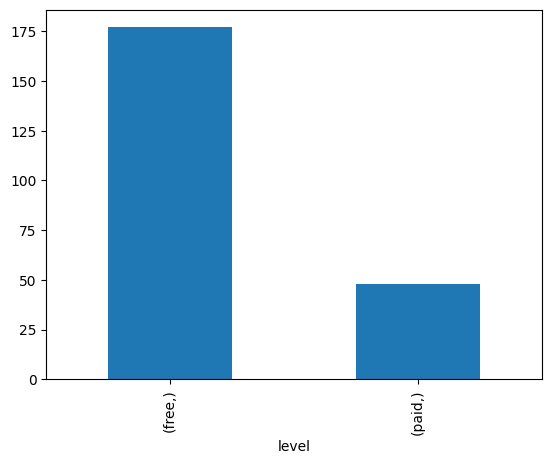

In [ ]:
ual = psdf[["userId", "level", "ts"]].toPandas()

ual = ual.sort_values("ts").drop_duplicates(subset="userId", keep="first")


ual = ual[["userId", "level"]].dropna(subset="userId")


ual[["level"]].value_counts().plot(kind="bar")

<Axes: xlabel='level'>

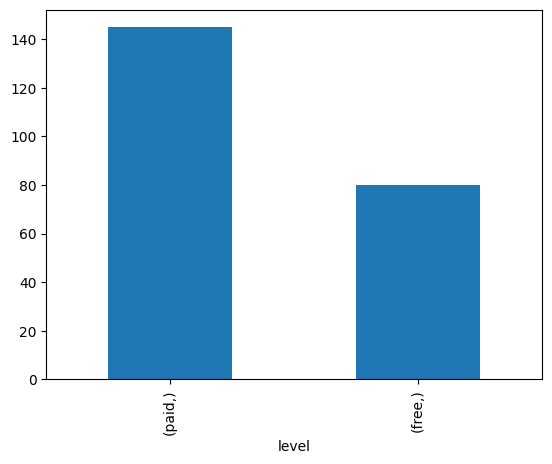

In [ ]:
ual = psdf[["userId", "level", "ts"]].toPandas()

ual = ual.sort_values("ts", ascending=False).drop_duplicates(
    subset="userId", keep="first"
)


ual = ual[["userId", "level"]].dropna(subset="userId")


ual[["level"]].value_counts().plot(kind="bar")

<Axes: xlabel='status'>

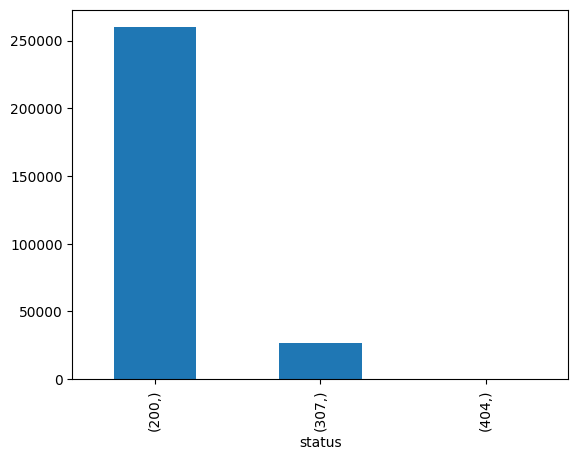

In [ ]:
status = spark.sql(
    """
    SELECT 
        status
    FROM user_log
          """
).toPandas()

status.value_counts().plot(kind="bar")

## Time Spent

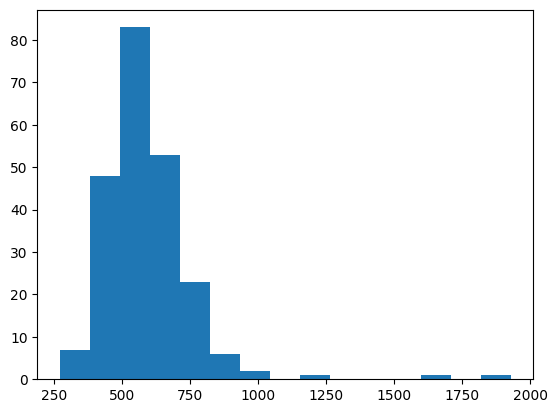

In [ ]:
tsl = psdf[["length", "sessionId", "userId"]].toPandas()

avg_session = (
    tsl.groupby(["userId", "sessionId"])
    .max()
    .reset_index()[["userId", "length"]]
    .groupby("userId")
    .mean()
    .round()
)
plt.hist(x=avg_session.length, bins=int(np.sqrt(len(avg_session.length))))
plt.show()